## Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from yellowbrick.regressor import PredictionError, ResidualsPlot
import matplotlib.pyplot as plt
import seaborn as sns

## Define the files to be loaded

In [2]:
# Participant number whose data should be loaded
participant_number = 2

# The version of the questionnaires to load
quest_version = 2

## Loading the pre-processed data

In [3]:
df = pd.read_csv('data/preprocessed/preprocessed_data_' + str(participant_number) + '_v' + str(quest_version) + '.csv')
df = df.drop(labels=['actual_day', 'actual_day.1'], axis=1)

df_oura = pd.read_csv('data/preprocessed/preprocessed_sleep_' + str(participant_number) + '_v' + str(quest_version) + '.csv')
df_oura = df_oura.drop(labels=['actual_day'], axis=1)

df_quest = pd.read_csv('data/preprocessed/preprocessed_questionnaires_' + str(participant_number) + '_v' + str(quest_version) + '.csv')
df_quest = df_quest.drop(labels=['actual_day'], axis=1)

In [4]:
# Remove these to try and fix the issues raised by LazyRegressor for them 
# example: 
# AdaBoostRegressor model failed to execute
# Found unknown categories ['[0.0, 51.0, 53.0, 53.0, 54.0, 53.0, ...
df = df.drop(labels=['hrv.items', 'heart_rate.items', 'sleep_phase_5_min', 'movement_30_sec', 'segment_state', 'type'], axis=1)
df_oura = df_oura.drop(labels=['hrv.items', 'heart_rate.items', 'sleep_phase_5_min', 'movement_30_sec', 'segment_state', 'type'], axis=1)

In [5]:
# Replace NaN values by 999 because NaN values can raise errors when fed to a regression model
df.fillna(999, inplace=True)
df_oura.fillna(999, inplace=True)
df_quest.fillna(999, inplace=True)

In [6]:
# Check for variables whose values are stored as string. This cannot be analyzed by the regression model
for i in range(len(df.columns)):
    if isinstance(df.iloc[1,i], str):
        print('column ' + df.columns[i])
        print('     ' + df.iloc[1,i])

## Define the analysis to be done

In [7]:
# For Oura and subjective sleep scores
variable_of_interest = 'score'
oura_drop_variables = ['score']
quest_drop_variables = ['subjective_sleep_score']

# # For average HRV
# variable_of_interest = 'average_hrv'
# oura_drop_variables = ['average_hrv']
# quest_drop_variables = []

## Apply Lasso

### Setting the data to be evaluated

In [8]:
# Separate the indenpendent variables from the dependent variables
y = df[variable_of_interest]
X = df.drop(labels=oura_drop_variables+quest_drop_variables, axis=1)
X_oura = df_oura.drop(labels=oura_drop_variables, axis=1)
X_quest = df_quest.drop(labels=quest_drop_variables, axis=1)

In [9]:
def lasso_model(X, y, random_state):
    # Hyperparameter tuning of the alpha value
    scaler = StandardScaler()
    X_scaler = scaler.fit_transform(X)

    # Define model
    model = Lasso(max_iter=10000)

    # Define and execute search
    search = GridSearchCV(model, param_grid = {'alpha':[.00001, 0.0001,0.001, 0.01]}, scoring='neg_mean_squared_error', n_jobs=1, cv=20)
    result = search.fit(X_scaler, y)

    # Print search results
    # print('Grid search results\nBest Score: %s' % result.best_score_)
    print('Grid search results\nBest alpha value: %s\n' % result.best_params_)

    # Splitting train and test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_state)

    model = Lasso(alpha=result.best_params_['alpha'])
    model.fit(X_train, y_train)

    print("Number of coefficients", len(model.coef_))
    print("Non-zero coeffcients", np.count_nonzero(model.coef_))
    print("Coefficients", model.coef_)
    return model, X_train, X_test, y_train, y_test 

In [10]:
# Compute R squared and mean square error of a given model and training and testing sets 
def compute_model(model, X_train, y_train, X_test, y_test):
    print('R squared training set', round(model.score(X_train, y_train), 3))
    print('R squared test set', round(model.score(X_test, y_test), 3))

    # Training data
    pred_train = model.predict(X_train)
    mse_train = mean_squared_error(y_train, pred_train)
    print('MSE training set', round(mse_train, 3))

    # Test data
    pred_test = model.predict(X_test)
    mse_test = mean_squared_error(y_test, pred_test)
    print('MSE test set', round(mse_test, 3))

    return pred_train, pred_test

### Using as independent variables all variables (Oura + questionnaire data)

In [11]:
reg, X_train, X_test, y_train, y_test = lasso_model(X, y, random_state=np.random.randint(50000))

Grid search results
Best alpha value: {'alpha': 0.001}

Number of coefficients 78
Non-zero coeffcients 44
Coefficients [ 0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.59312852e-03
 -1.35732353e-05 -1.13588273e-04  9.32879162e-05  0.00000000e+00
 -1.03096826e-04 -0.00000000e+00  7.46209525e-03  3.29101988e-03
  9.53411000e-03  6.61938352e-03  1.17895018e-02  8.04335141e-03
  3.54397427e-02 -7.65226753e-05 -0.00000000e+00  0.00000000e+00
  5.53954974e-05 -8.53532845e-05 -6.54414712e-04  4.15321813e-07
  0.00000000e+00  3.44656327e-04  9.75998753e-04 -3.31217203e-04
  3.12016117e-05  4.34725947e-03 -4.75430424e-04 -3.88828583e-04
  4.24264560e-04 -6.04012148e-04 -6.05618754e-04 -0.00000000e+00
 -6.64098546e-05 -0.00000000e+00  1.99059338e-04 -7.67922719e-05
 -3.57848056e-06 -1.56491885e-04  2.01718249e-05 -2.10245541e-03
 -5.60834414e-07 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.

/Users/user/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.390e-02, tolerance: 4.968e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


In [12]:
selected_features = []
for i in range(len(reg.coef_)):
    if reg.coef_[i] != 0:
        selected_features.append(X_train.columns[i])

print('Number of selected features', len(selected_features))
selected_features

Number of selected features 44


['average_heart_rate',
 'average_hrv',
 'awake_time',
 'bedtime_end_delta',
 'bedtime_start_delta',
 'contributors.deep_sleep',
 'contributors.efficiency',
 'contributors.latency',
 'contributors.rem_sleep',
 'contributors.restfulness',
 'contributors.timing',
 'contributors.total_sleep',
 'deep_sleep_duration',
 'latency',
 'light_sleep_duration',
 'lowest_heart_rate',
 'lowest_heart_rate_time_offset',
 'readiness.contributors.activity_balance',
 'readiness.contributors.body_temperature',
 'readiness.contributors.hrv_balance',
 'readiness.contributors.previous_day_activity',
 'readiness.contributors.previous_night',
 'readiness.contributors.recovery_index',
 'readiness.contributors.resting_heart_rate',
 'readiness.contributors.sleep_balance',
 'readiness.score',
 'readiness.temperature_deviation',
 'rem_sleep_duration',
 'restless_periods',
 'sleep_midpoint',
 'time_in_bed',
 'timezone',
 'total_sleep_duration',
 'wake_ups',
 'prev_oura_score',
 'prev_subjective_score',
 'Socially act

In [13]:
pred_train, pred_test = compute_model(reg, X_train, y_train, X_test, y_test)

R squared training set 0.999
R squared test set 0.994
MSE training set 0.0
MSE test set 0.002


### Visualizing the results
#### How off the predicted values were for the test set

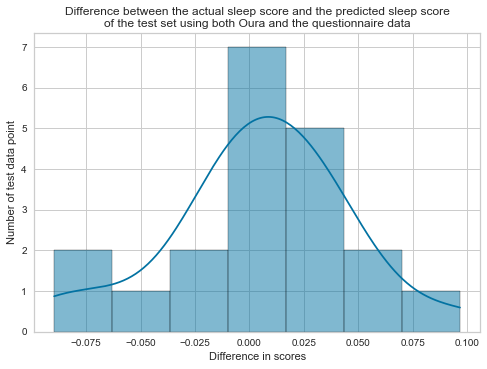

In [14]:
ax = sns.histplot(y_test-pred_test, kde=True)
ax.set(xlabel='Difference in scores', ylabel='Number of test data point', 
       title='Difference between the actual sleep score and the predicted sleep score\nof the test set using both Oura and the questionnaire data')
plt.show()

#### Prediction error plot
It plots the actual targets from the dataset against the predicted values generated by the Lasso model, thereby showing how much variance is in the model.

/Users/user/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  "X does not have valid feature names, but"


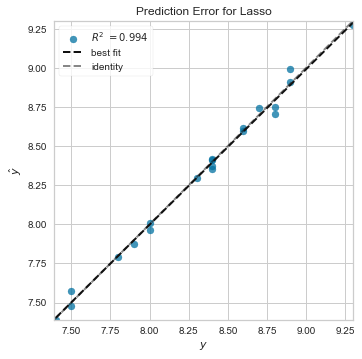

<AxesSubplot:title={'center':'Prediction Error for Lasso'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [15]:
visualizer = PredictionError(reg)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
visualizer.poof()

#### Residuals plot
Residuals are the difference between the true value of the target variable and the predicted value. Thus, it is the error of the prediction. The difference between residuals is shown in a residuals plot, plotted against the predicted dependent variables along with the distribution of residuals.

/Users/user/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  "X does not have valid feature names, but"


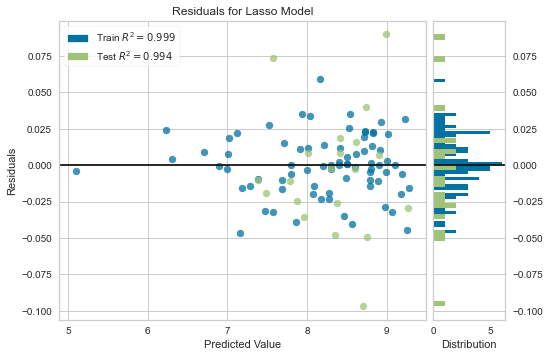

<AxesSubplot:title={'center':'Residuals for Lasso Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [16]:
visualizer = ResidualsPlot(reg)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
visualizer.poof()

## Apply LassoCV
### Using as independent variables all variables (Oura + questionnaire data)

In [17]:
lasso_cv = LassoCV(alphas=np.arange(0.01, 5, 0.01), cv=5, max_iter=10000)
lasso_cv.fit(X_train, y_train)

print('Best alpha:', lasso_cv.alpha_, '\n')
pred_train, pred_test = compute_model(lasso_cv, X_train, y_train, X_test, y_test)

Best alpha: 0.05 

R squared training set 0.997
R squared test set 0.988
MSE training set 0.002
MSE test set 0.003


/Users/user/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.280e-02, tolerance: 4.968e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


### Using as independent variables only the Oura data
#### Lasso

In [18]:
reg_oura, X_train_oura, X_test_oura, y_train_oura, y_test_oura = lasso_model(X_oura, y, random_state=995)

Grid search results
Best alpha value: {'alpha': 0.001}

Number of coefficients 47
Non-zero coeffcients 34
Coefficients [-8.73343972e-05  0.00000000e+00 -1.96907765e-04 -0.00000000e+00
  0.00000000e+00 -1.27444497e-04 -7.16864770e-05  1.00497280e-04
  3.66839800e-18 -1.06069702e-04 -0.00000000e+00  8.24922329e-03
  6.88194644e-03  7.47897212e-03  8.29838102e-03  1.31541153e-02
  8.56716763e-03  3.30670511e-02 -7.41714838e-05 -0.00000000e+00
  0.00000000e+00  7.86282682e-05 -7.81838965e-05 -2.25613333e-03
 -1.80443895e-06 -0.00000000e+00  1.21550153e-04  1.57096394e-05
 -1.11173063e-04  0.00000000e+00  3.80060902e-03 -3.52370248e-04
 -5.64169356e-04  4.82232016e-05  3.99880488e-04 -0.00000000e+00
 -0.00000000e+00 -6.85440694e-05  0.00000000e+00  0.00000000e+00
  3.73415340e-06 -4.60625129e-05  3.45342418e-06  1.78281450e-05
 -1.67701199e-03 -2.52979223e-04  0.00000000e+00]


/Users/user/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.349e-02, tolerance: 3.820e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


In [19]:
pred_train, pred_test = compute_model(reg_oura, X_train_oura, y_train_oura, X_test_oura, y_test_oura)

R squared training set 0.999
R squared test set 0.987
MSE training set 0.001
MSE test set 0.011


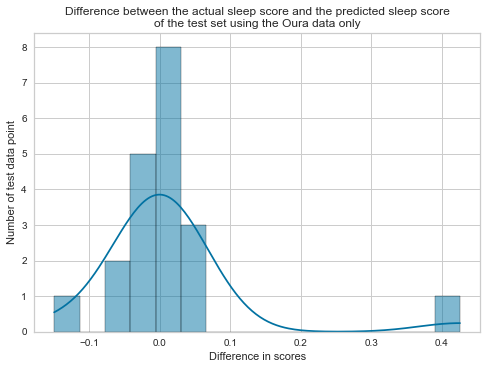

/Users/user/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  "X does not have valid feature names, but"


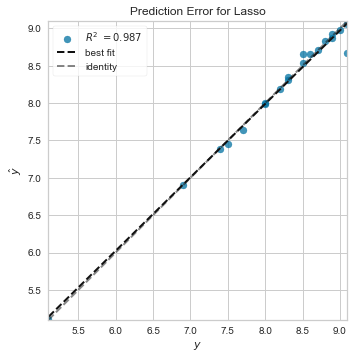

/Users/user/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  "X does not have valid feature names, but"


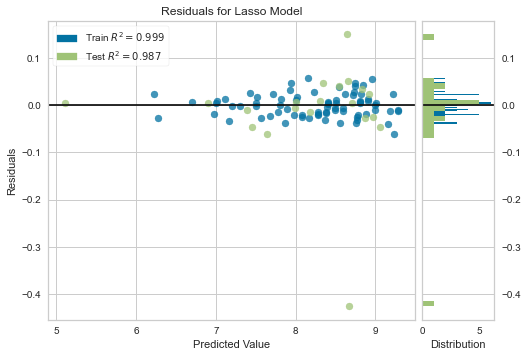

<AxesSubplot:title={'center':'Residuals for Lasso Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [20]:
# How off the predicted values were for the test set
ax = sns.histplot(y_test_oura-pred_test, kde=True)
ax.set(xlabel='Difference in scores', ylabel='Number of test data point', 
       title='Difference between the actual sleep score and the predicted sleep score\nof the test set using the Oura data only')
plt.show()

# Prediction Error Plot
visualizer = PredictionError(reg_oura)
visualizer.fit(X_train_oura, y_train_oura)  
visualizer.score(X_test_oura, y_test_oura)  
visualizer.poof()

# Residuals Plot
visualizer = ResidualsPlot(reg_oura)
visualizer.fit(X_train_oura, y_train_oura)  
visualizer.score(X_test_oura, y_test_oura)  
visualizer.poof()

## Applying the same model on the questionnaire data only

In [21]:
reg_quest, X_train_quest, X_test_quest, y_train_quest, y_test_quest = lasso_model(X_quest, y, random_state=995)

/Users/user/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.907e+00, tolerance: 5.331e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/Users/user/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.292e+00, tolerance: 5.271e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/Users/user/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might wan

Grid search results
Best alpha value: {'alpha': 0.01}

Number of coefficients 33
Non-zero coeffcients 16
Coefficients [-5.66660837e-03 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -9.30512889e-03  1.76030574e-02 -0.00000000e+00
  7.43791156e-04  0.00000000e+00 -5.14527500e-01 -1.21479684e-01
 -0.00000000e+00  2.76196416e-04 -4.90802640e-03 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -7.83176533e-01 -4.87422845e-02
 -9.53997786e-05 -0.00000000e+00 -1.19548039e-04  8.29837191e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00  4.02327518e-02  0.00000000e+00 -3.40260980e-04
  1.87796726e-04]


/Users/user/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.889e+00, tolerance: 5.427e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/Users/user/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.092e+00, tolerance: 5.290e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/Users/user/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might wan

In [22]:
pred_train, pred_test = compute_model(reg_quest, X_train_quest, y_train_quest, X_test_quest, y_test_quest)

R squared training set 0.518
R squared test set 0.523
MSE training set 0.239
MSE test set 0.405


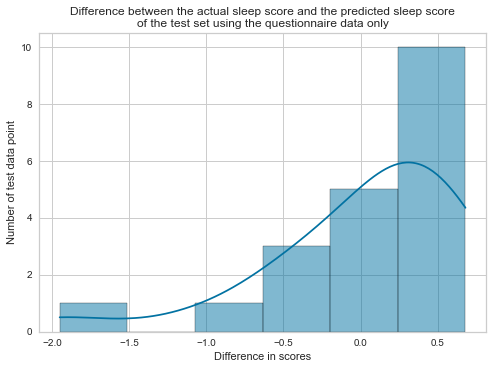

/Users/user/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  "X does not have valid feature names, but"


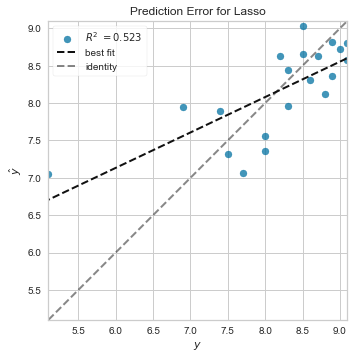

/Users/user/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  "X does not have valid feature names, but"


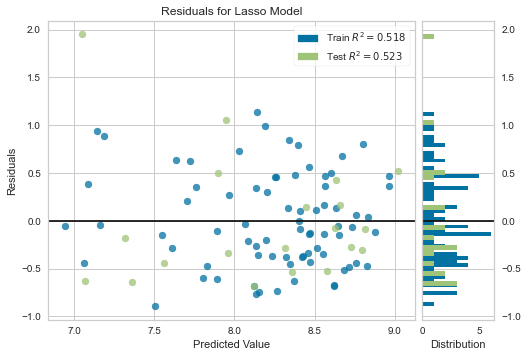

<AxesSubplot:title={'center':'Residuals for Lasso Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [23]:
# How off the predicted values were for the test set
ax = sns.histplot(y_test_quest-pred_test, kde=True)
ax.set(xlabel='Difference in scores', ylabel='Number of test data point', 
       title='Difference between the actual sleep score and the predicted sleep score\nof the test set using the questionnaire data only')
plt.show()

# Prediction Error Plot
visualizer = PredictionError(reg_quest)
visualizer.fit(X_train_quest, y_train_quest)  
visualizer.score(X_test_quest, y_test_quest)  
visualizer.poof()

# Residuals Plot
visualizer = ResidualsPlot(reg_quest)
visualizer.fit(X_train_quest, y_train_quest)  
visualizer.score(X_test_quest, y_test_quest)  
visualizer.poof()